In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
from scipy import stats
import statistics
import dabest as db

In [8]:
#Reading in the metadata
base_folder = plb.Path('C:/Users/Emily/Desktop/current_analysis/Tax-4 mutant pooled data/')
md_path = base_folder.joinpath('salva.csv')
md_df = pd.read_csv(md_path)

#Dropping unecessary columns and altering data types
md_df = md_df.drop(columns=['ID', 'Passes QC'])
md_df['Plate ID'] = md_df['Plate ID'].fillna(0).astype(int)
print(len(md_df))

#filtering for wells that have >= 150 worms
over_150 = md_df[md_df['Total Worms'] >= 150]
print(len(over_150))

144
102


In [12]:
strains = over_150['Strain'].unique()
compounds = over_150['Compound'].unique()

array(['DMSO', 'SA'], dtype=object)

In [9]:
over_150.head()

,Chemotaxis,Compound,Strain,File Name,WellNo,Total Worms,Plate ID
0,0.214286,DMSO,AL,20211122_SA_tax-4mut_001,1A,232.0,1
1,0.152866,DMSO,CO,20211122_SA_tax-4mut_001,1B,362.0,1
3,-0.007092,DMSO,GA,20211122_SA_tax-4mut_001,1D,323.0,1
4,-0.011673,DMSO,AL,20211122_SA_tax-4mut_001,2A,302.0,2
5,0.194539,DMSO,CO,20211122_SA_tax-4mut_001,2B,333.0,2


In [25]:
def get_worm_locs(row, wrms, result_dict): 
    
    filename = row['File Name']
    well = row['WellNo']

    filepath = base_folder.joinpath('loc_' + filename + '_' + well + '.csv')
    #temp = pd.read_csv(loc_fname)
    
    
    if filepath.is_file():
        data = pd.read_csv(filepath)
        strain = row['Strain']
        xs = data['X']

        if strain in result_dict:
            result_dict[strain] = result_dict[strain].append(xs)
            result_dict[strain].reset_index(inplace=True, drop=True)
            #result_dict[strain] = result_dict[strain]+xs
        else:
            result_dict[strain]=xs
        return result_dict
    
    else: 
        pass
    

In [26]:
def subst(df, strain, compound, path):
    temp = df.loc[(df['Strain']==strain) & 
            (df['Compound']==compound)]
    # Need to create an empty dictionary to hold the values
    return temp

In [35]:
# 1 inch = 25.4mm
mm = 25.4
# 1200 pixels per 25.4mm
px_mm = 1200/mm

In [45]:
all_strains = pd.DataFrame()
compound = 'SA'

i = 0
for s in strains:
    test = subst(over_150, s, compound, base_folder)
    all_strains = all_strains.append(test)
    
# Need to create an empty dictionary to hold the values
results_dict = {}
for index, row in all_strains.iterrows():
    pooled = get_worm_locs(row, base_folder, results_dict)

pooled_df = pd.DataFrame.from_dict(pooled)
#mm_df = pooled_df.apply(lambda x: -(x/px_mm)+32.5)
pooled_df.to_csv(base_folder.joinpath(compound+'_dpi.csv'))
#mm_df.to_csv(base_folder.joinpath(compound+'_mm.csv'))


In [46]:
db_obj = db.load(pooled_df, idx=strains)

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 11.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\envs\neuroplant\l

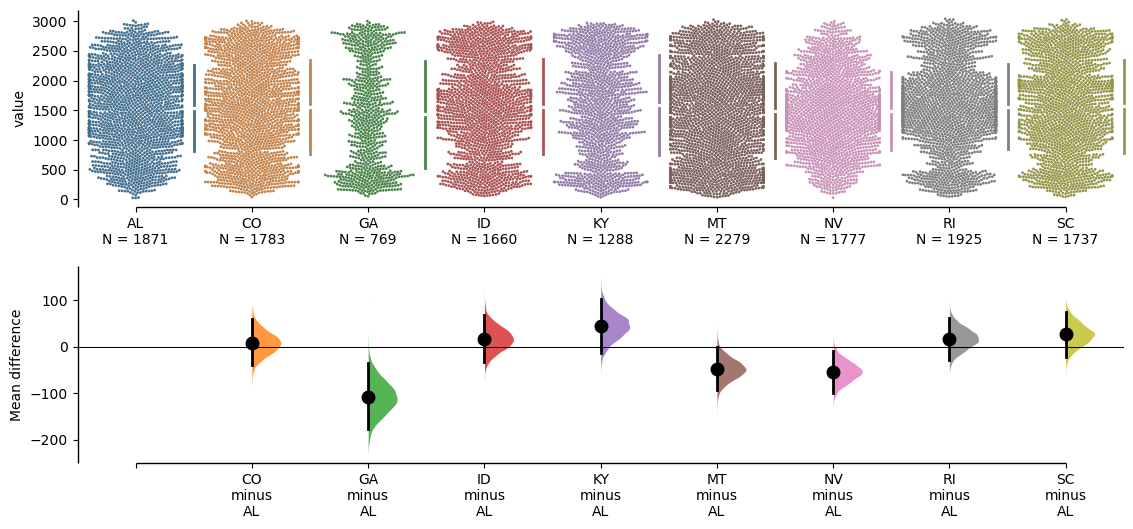

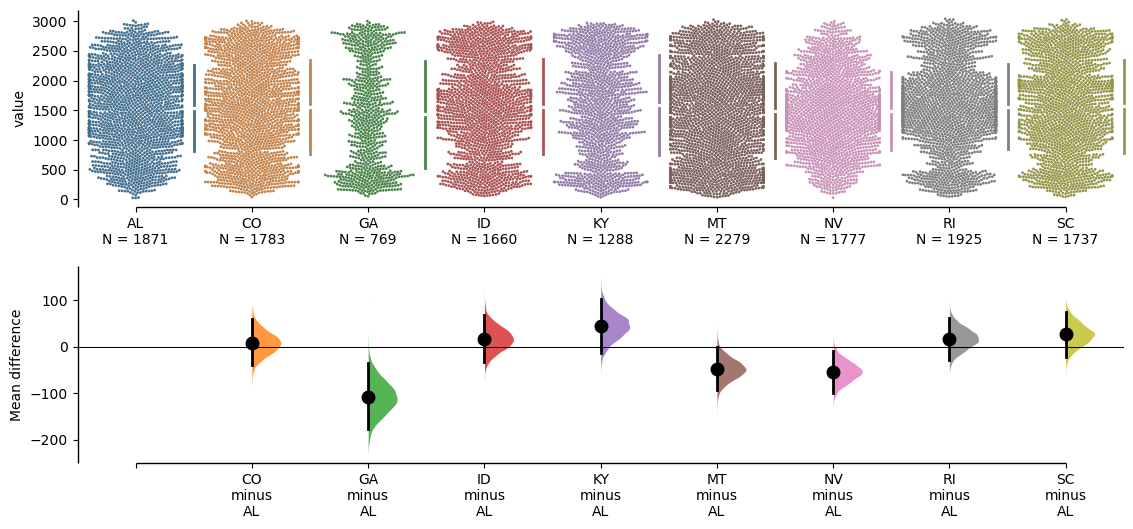

In [47]:
db_obj.mean_diff.plot(raw_marker_size=2)